# <font color='blue'>Deep Learning II</font>

# Prevendo Séries Temporais com Stateful LSTMs 

Este Notebook está dividido nas seguintes etapas. Clique no título da etapa para acessá-la diretamente.

* [Etapa 1](#etapa1): Conjunto de dados
* [Etapa 2](#etapa2): Importar as Bibliotecas
* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

## LSTMs Stateful x Stateless

Uma LSTM prevê com base na ativação da célula de memória no timestep anterior. Você então deve copiar essa ativação entre lotes? Ou você define todas as ativações como zeros? Isso é o que distingue uma LSTM com estado (stateful) e sem estado (stateless). Portanto, o estado refere-se a ativações de neurônios, não aos parâmetros (que são mantidos em ambos os casos).

Quando devemos usar LSTMs em modo stateful ou stateless?

Depende se você deseja que as previsões no lote n dependam do estado no lote n-1. Por exemplo, na modelagem de linguagem, os lotes sucessivos são trocas sucessivas de texto, por isso faz sentido manter o estado. Mas se você sabe que os lotes sucessivos não estão relacionados entre si, talvez seja mais sensato redefinir o estado.

"Stateless" é como redefinir a LSTM para um "estado inicial" a cada novo lote, e 'stateful' significa que você continua de onde você está. Em ambos os casos, a LSTM está aprendendo porque as probabilidades de transição são atualizadas.

A LSTM stateless deve ser usada se as instâncias de diferentes lotes forem independentes, por exemplo, ao modelar padrões de nível de sentença e cada instância for uma frase - o estado deve ser redefinido para "início de sentença" para cada nova instância. LSTM stateful é mais útil se houver continuidade entre a iª instância de todos os lotes, por exemplo, ao modelar padrões de nível de documento (sem redefinir os limites das orações) ou séries temporais. Neste caso, a i-ésima instância de cada lote deve ser as frases consequentes do i-ésimo documento.

Memória Entre Batches
A rede LSTM possui memória que é capaz de se lembrar através de sequências longas. Normalmente, o estado dentro da rede é reiniciado após cada lote de treinamento ao chamar modelo.fit(), bem como cada chamada para model.predict() ou model.evaluate(). Nós podemos controlar quando o estado interno da rede LSTM é apagado no Keras, fazendo a camada LSTM com estado (usando o parâmetro stateful). Isso significa que podemos criar estado em toda a sequência de treinamento e até mesmo manter esse estado, se necessário, para fazer previsões.

Esta técnica exige que os dados de treino não sejam "shuffled" durante o treinamento da rede. Também requer reinicialização explícita do estado da rede após cada exposição aos dados de treinamento (epoch) com chamadas para model.reset_states(). Isso significa que devemos criar nosso próprio ciclo externo de épocas e dentro de cada epoch, fazer as chamadas a model.fit() e model.reset().

O módulo reset_states() limpa apenas os estados ocultos da sua rede. Vale a pena mencionar que, dependendo se a opção stateful = True foi configurada em sua rede - o comportamento desta função pode ser diferente. Se não estiver configurado - todos os estados são reiniciados automaticamente após cada cálculo de lote em sua rede (por exemplo, depois de chamar model.fit(), model.predict() e model.evaluate()). Caso contrário - você deve chamar reset_states() toda vez, quando quiser fazer chamadas de modelo consecutivas independentes.

Stateful = True geralmente é usado quando você deseja tratar lotes consecutivos como entradas consecutivas. Neste caso, o modelo está tratando lotes consecutivos como se estivessem no mesmo batch.

Quando a camada LSTM for criada, o parâmetro stateful = True deve ser definido e ao invés de especificar a dimensão de entrada, devemos informar o número de amostras em um batch, o número de time steps na amostra e o número de features no time step configurando o parâmetro batch_input_shape. Nossa camada LSTM ficará assim:

model.add(LSTM(4, batch_input_shape = (batch_size, look_back, 1), stateful = True))

O mesmo batch_size deve ser usado mais tarde para fazer as previsões: model.predict(trainX, batch_size=batch_size)

Configurar uma RNN com stateful = True significa que os estados para as amostras de cada lote serão reutilizados como estados iniciais para as amostras no próximo lote.

<a id = 'etapa1'></a>
## Etapa 1: Conjunto de dados

Previsão de arrecadação de ICMS.

Usaremos conjuntos de dados que mostram a arrecadação de ICMS. Os dados tem registros dos anos de 2010 a 2015.

Será fornecido 1 dataset com 2 colunas, data e arrecadação de icms. 

<a id='etapa2'></a>
## Etapa 2: Importar as Bibliotecas

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [2]:
import keras as k
k.__version__

Using TensorFlow backend.


'2.3.1'

In [3]:
# Imports
import math
import numpy
import pandas
import os
import io
import requests

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import load_model

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [4]:
# Converte array em matriz
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [5]:
# Define o PATH onde estão os dados
save_path = "./save"

# Random seed 
numpy.random.seed(7)

look_back = 6

Clique no título da etapa para acessá-la diretamente.

* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

<a id='etapa3'></a>
## Etapa 3: Criar o Modelo

In [6]:
# Carrega o dataset já ordenado por data
dataframe = pandas.read_csv("Arrecadacao_icms.csv", usecols = [1], engine = 'python')
datasetfull = dataframe.values
datasetfull = datasetfull.astype('float32')

In [7]:
# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

In [8]:
# Normaliza os dados
# As LSTMs são sensíveis à escala dos dados de entrada, especificamente quando funções de ativação sigmoide (padrão)
# ou tanh são usadas. Pode ser uma boa prática redimensionar os dados para o range de 0 a 1, 
# também chamado de normalização. Podemos normalizar facilmente o conjunto de dados usando a classe MinMaxScaler do scikit-learn
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

In [9]:
# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [10]:
dataset.shape

(72, 1)

In [11]:
train.shape

(48, 1)

In [12]:
valid.shape

(24, 1)

In [13]:
test.shape

(24, 1)

In [14]:
# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))

In [15]:
# Cria o modelo LSTM
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape = (batch_size, look_back, 1), stateful = True))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
for i in range(200):
    model.fit(trainX, trainY, epochs = 1, batch_size = batch_size, verbose = 2, shuffle = False)
    model.reset_states()

Epoch 1/1
 - 1s - loss: 0.0278
Epoch 1/1
 - 0s - loss: 0.0228
Epoch 1/1
 - 0s - loss: 0.0230
Epoch 1/1
 - 0s - loss: 0.0227
Epoch 1/1
 - 0s - loss: 0.0225
Epoch 1/1
 - 0s - loss: 0.0223
Epoch 1/1
 - 0s - loss: 0.0222
Epoch 1/1
 - 0s - loss: 0.0221
Epoch 1/1
 - 0s - loss: 0.0220
Epoch 1/1
 - 0s - loss: 0.0219
Epoch 1/1
 - 0s - loss: 0.0219
Epoch 1/1
 - 0s - loss: 0.0218
Epoch 1/1
 - 0s - loss: 0.0217
Epoch 1/1
 - 0s - loss: 0.0217
Epoch 1/1
 - 0s - loss: 0.0217
Epoch 1/1
 - 0s - loss: 0.0216
Epoch 1/1
 - 0s - loss: 0.0216
Epoch 1/1
 - 0s - loss: 0.0216
Epoch 1/1
 - 0s - loss: 0.0215
Epoch 1/1
 - 0s - loss: 0.0215
Epoch 1/1
 - 0s - loss: 0.0215
Epoch 1/1
 - 0s - loss: 0.0214
Epoch 1/1
 - 0s - loss: 0.0214
Epoch 1/1
 - 0s - loss: 0.0214
Epoch 1/1
 - 0s - loss: 0.0214
Epoch 1/1
 - 0s - loss: 0.0213
Epoch 1/1
 - 0s - loss: 0.0213
Epoch 1/1
 - 0s - loss: 0.0213
Epoch 1/1
 - 0s - loss: 0.0213
Epoch 1/1
 - 0s - loss: 0.0213
Epoch 1/1
 - 0s - loss: 0.0212
Epoch 1/1
 - 0s - loss: 0.0212
Epoch 1/

In [16]:
# Salvando a rede inteira no formato HDF5 (salvando todos os componentes da rede, incluindo os pesos)
model.save(os.path.join(save_path,"RNN02_arrecadacao_LSTM_Stateful.h5"))

<a id='etapa4'></a>
## Etapa 4: Testar o Modelo

## Agora recarregamos o modelo para realizamos uma previsão.

In [17]:
# Carrega o dataset já ordenado por data
dataframe = pandas.read_csv("Arrecadacao_icms.csv", usecols = [1], engine = 'python')
datasetfull = dataframe.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))

In [18]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_arrecadacao_LSTM_Stateful.h5"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Previsões
trainPredict = model.predict(trainX, batch_size = batch_size)
model.reset_states()
validPredict = model.predict(validX, batch_size = batch_size)

In [20]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])

In [21]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))

Score em Treino: 436312.4550 RMSE
Score em Validação: 561177.1603 RMSE


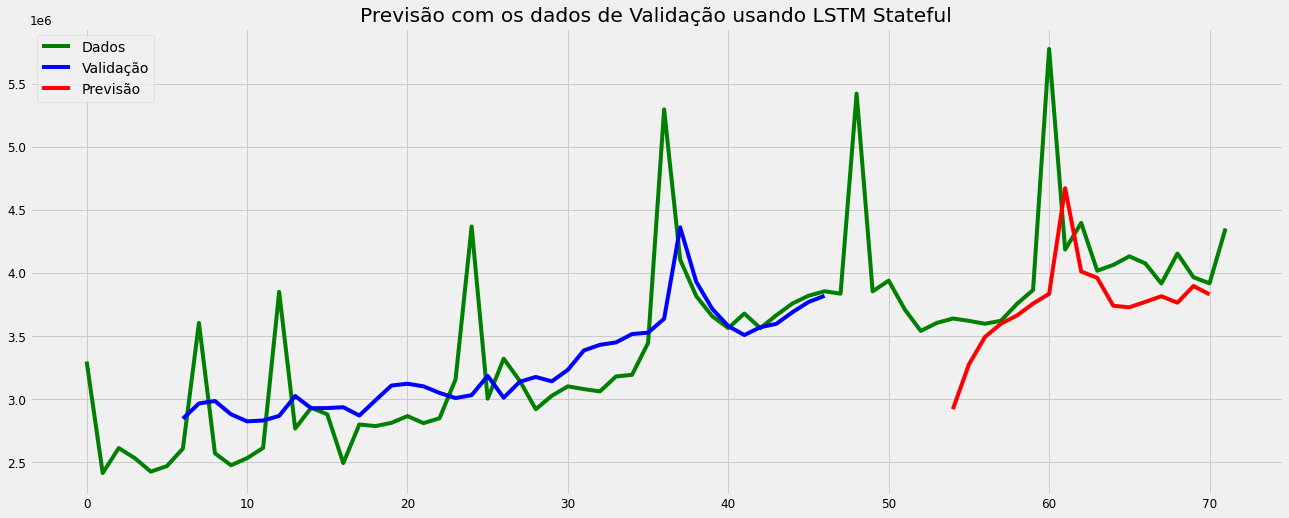

In [22]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação usando LSTM Stateful") 
plt.plot(scaler.inverse_transform(dataset), label = 'Dados', color = 'green')
plt.plot(trainPredictPlot, color = 'blue', label = 'Validação')
plt.plot(validPredictPlot, color = 'red', label = 'Previsão')
plt.legend(loc = 'upper left') 
plt.show()

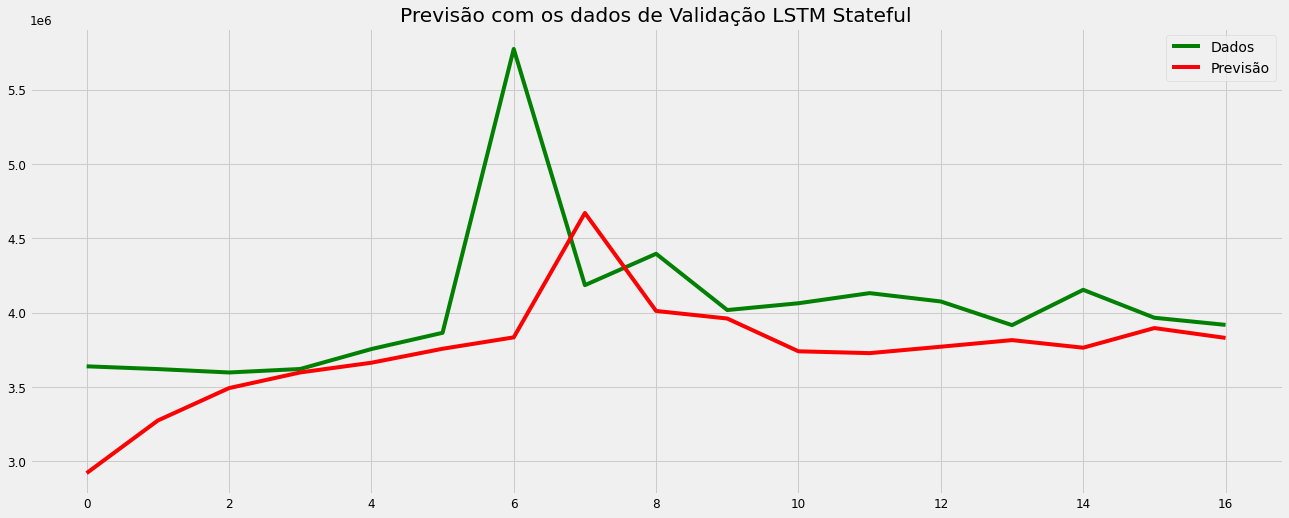

In [23]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação LSTM Stateful") 
plt.plot(validY[0], label = 'Dados', color = 'green') 
plt.plot(validPredict[:,0], label = 'Previsão', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

<a id='etapa5'></a>
## Etapa 5: Realizar as Previsões

## Vamos fazer o Forecasting para 24 meses de horizonte de previsão. 

In [24]:
# Carrega o dataset já ordenado por data
dataframe = pandas.read_csv("Arrecadacao_icms.csv", usecols = [1], engine = 'python')
datasetfull = dataframe.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Normaliza os dados de Teste
scalerTeste = MinMaxScaler(feature_range = (0, 1))
testScaler = scalerTeste.fit_transform(test)

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(testScaler, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [25]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_arrecadacao_LSTM_Stateful.h5"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Previsões com dados de Teste
trainPredict = model.predict(trainX, batch_size = batch_size)
model.reset_states()
validPredict = model.predict(validX, batch_size = batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size = batch_size)

In [27]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scalerTeste.inverse_transform(testPredict)
testY = scalerTeste.inverse_transform([testY])

In [28]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.4f RMSE' % (testScore))

Score em Treino: 436312.4550 RMSE
Score em Validação: 561177.1603 RMSE
Score em Teste: 657560.4979 RMSE


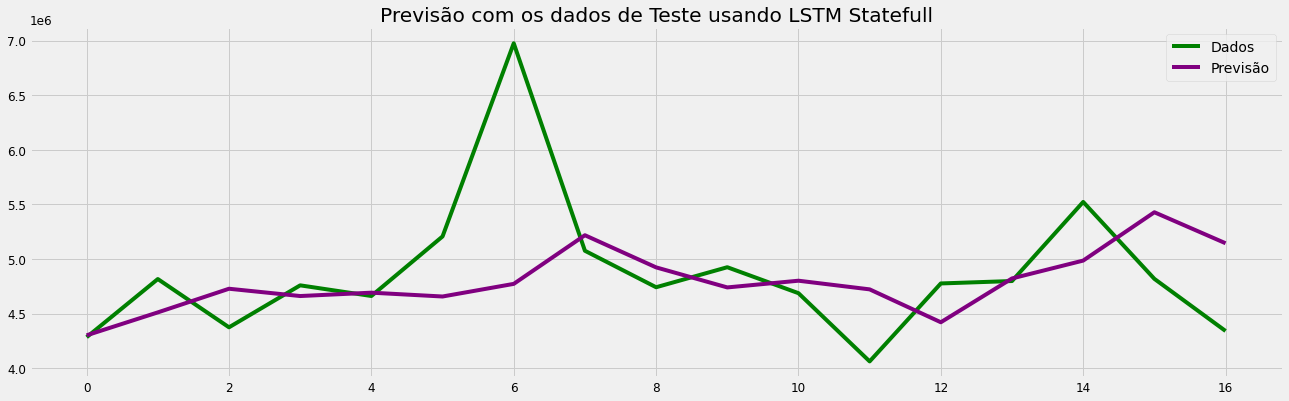

In [29]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Teste usando LSTM Statefull") 
plt.plot(testY[0], label = 'Dados', color = 'green') 
plt.plot(testPredict[:,0], label = 'Previsão', color = 'purple') 
plt.legend(loc = 'best') 
plt.show()

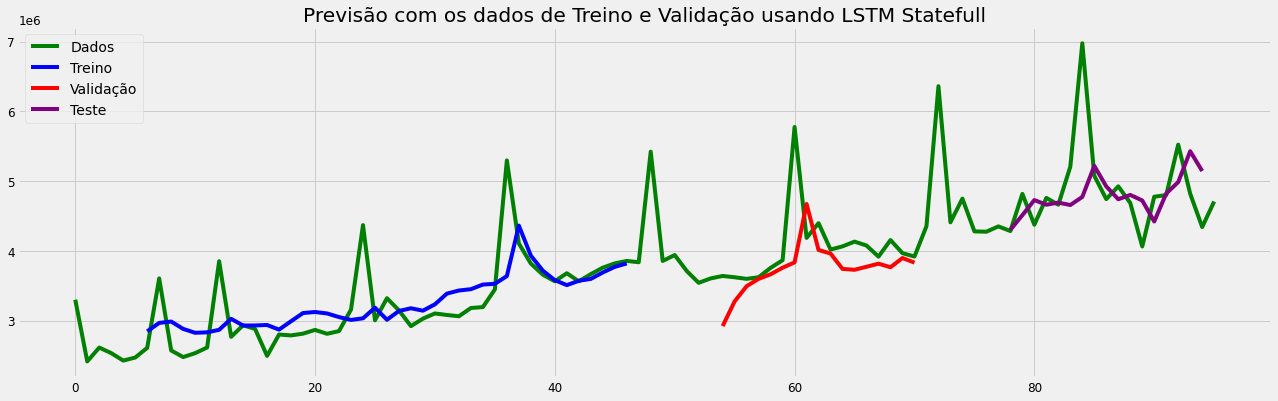

In [31]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(datasetfull)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict             

# Ajusta as previsões em validação para o plot
testPredictPlot = numpy.empty_like(datasetfull)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[(len(trainPredict) + len(validPredict))+(look_back*3)+2:len(datasetfull)-1, :] = testPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Treino e Validação usando LSTM Statefull") 
#plt.plot(datasetfull, label = 'Dados', color = 'green')
plt.plot(datasetfull, label = 'Dados',color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(validPredictPlot, label = 'Validação', color = 'red')
plt.plot(testPredictPlot, label = 'Teste', color = 'purple')
plt.legend(loc = 'upper left') 
plt.show()

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim